# Sentence categorical feature evolution

## 1 Setup

Flags

In [1]:
SAVE_FIGURES = False
STOPWORDS = 'include'  # 'include' or 'exclude'

Setup the database

In [2]:
import os, sys
sys.path.insert(1, os.path.abspath('../..'))
import analysis

FIG = os.path.join(os.path.abspath(os.path.curdir), '{}.png')
DB_NAME = 'spreadr_' + os.path.split(os.path.abspath(os.path.curdir))[1]
analysis.setup(DB_NAME)
print('Database:', DB_NAME)

Database: spreadr_exp_3


Imports for the analysis

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.patches import Patch
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sb
from progressbar import ProgressBar
from statsmodels.stats.proportion import multinomial_proportions_confint

from gists.models import Sentence, Tree, GistsConfiguration

from analysis.utils import memoized, mpl_palette, get_nlp

config = GistsConfiguration.get_solo()
nlp = get_nlp()

## 2 Long-term sentence feature evolution

### 2.0 Setup

Then build the master DataFrame that we'll plot below

In [4]:
def base(sentence):
    return {
        # indices
        'tree_id': sentence.tree.id,
        'sentence_id': sentence.id,
        'branch_id': sentence.head.id if sentence.parent is not None else np.nan,
        # independent variables
        'depth': sentence.depth,
        'is_root': sentence.parent is None,
    }

def rows(sentence):
    for fname in Sentence.CATEGORICAL_WORD_FEATURES:
        sentence_values = sentence.features(fname, stopwords=STOPWORDS)
        for value in sentence_values:
            row = base(sentence)
            row.update({'feature': fname, 'value': value})
            yield row

In [5]:
data = []
for tree in ProgressBar(max_value=Tree.objects.experiment.count())(Tree.objects.experiment):
    for sentence in tree.sentences.kept:

        if sentence.depth > config.target_branch_depth:
            # Ignore out-of-shape sentences
            continue
        
        for row in rows(sentence):
            data.append(row)

data = pd.DataFrame(data)

features = sorted(set(data.feature))
index = sorted(set(data.columns).difference(['value', 'feature']))

100% (50 of 50) |#########################| Elapsed Time: 0:02:56 Time: 0:02:56


In [6]:
# Weight is 1, at first
data['weight'] = 1 * np.isfinite(data.value)

# Divided by the number of words counted (and coded) in the sentence
print('Computing word weights for all appearances')
data['weight'] = data\
    .groupby(['sentence_id', 'feature'])['weight']\
    .transform(lambda x: x / data.loc[x.index]['weight'].sum())

Computing word weights for all appearances


Our plotting function

In [7]:
def plot_categorical_evolution(data, barwidth=.8, rename_index=None, plot_kws={}):
    # Massage the data
    cat = data\
        .groupby(['depth', 'value'], as_index=False).weight\
        .aggregate({'count': 'sum'})
    cat_totals = cat.groupby('depth')['count'].sum()
    cat['count'] = cat.groupby('depth')['count'].transform(lambda x: x / x.sum())
    cat_value = cat\
        .pivot(index='value', columns='depth', values='count')\
        .dropna()
    if rename_index is not None:
        cat_value = cat_value.rename(index=rename_index)
    
    # Plot
    
    ax = cat_value.plot(kind='bar', width=barwidth, **plot_kws)
    ax.set_xlabel('Proportion in sentences at depth n')
    # Plot root and leaf CIs
    max_depth = int(cat.depth.max())
    barstep = barwidth / max_depth
    root_cis = multinomial_proportions_confint((cat_value[0] * cat_totals[0]).round(),
                                               method='goodman')
    leaf_cis = multinomial_proportions_confint((cat_value[max_depth] * cat_totals[max_depth]).round(),
                                               method='goodman')
    for i in range(len(cat_value)):
        ax.plot([i - barstep * (max_depth - 1) / 2, i - barstep * (max_depth - 1) / 2],
                 root_cis[i], lw=2, color='grey', label='95% CI' if i == 0 else None)
        ax.plot([i + barstep * (max_depth - 1) / 2, i + barstep * (max_depth - 1) / 2],
                 leaf_cis[i], lw=2, color='grey')
    leg_handles, leg_labels = ax.get_legend_handles_labels()
    # Fix legend labels
    labels = []
    for label in leg_labels:
        try:
            int(label)
            labels.append('depth = {}'.format(label))
        except ValueError:
            labels.append(label)
    # Plot legend
    ax.legend(leg_handles, labels, loc='upper left')
    
    return ax

### 2.1 POS

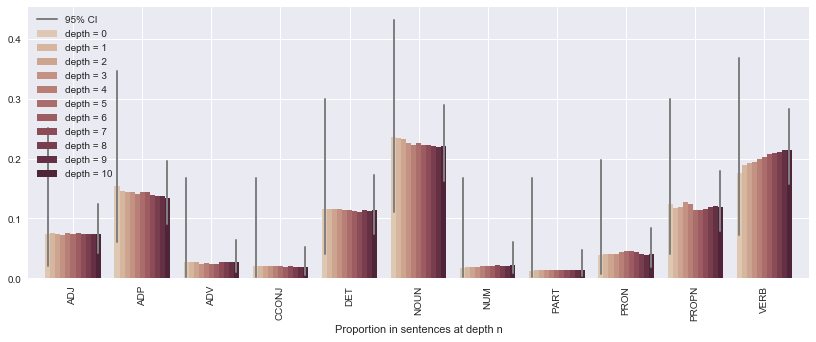

In [8]:
plot_categorical_evolution(data[(data.feature == 'pos') & (data.value != 99)],
                           rename_index=lambda n: nlp.vocab.strings[int(n)],
                           plot_kws={'figsize': (14, 5),
                                     'colormap': sb.cubehelix_palette(start=.5,
                                                                      rot=.3,
                                                                      as_cmap=True,
                                                                      light=.8,
                                                                      dark=.2)})

### 2.2 Dependencies

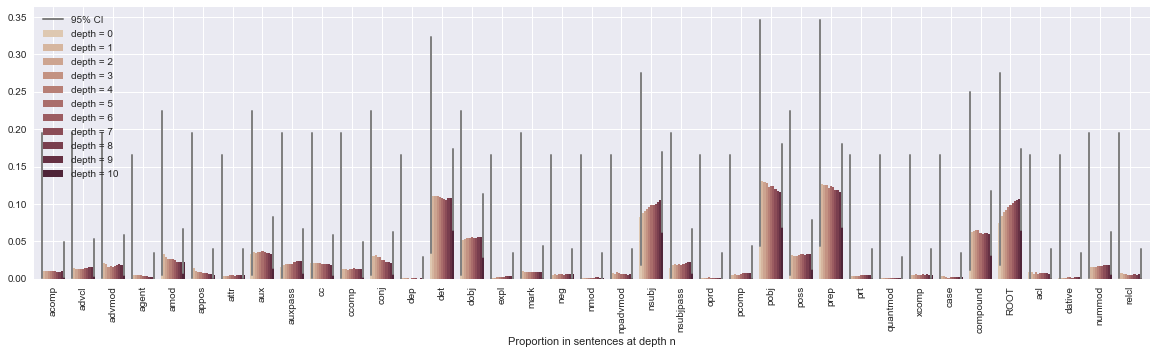

In [9]:
plot_categorical_evolution(data[data.feature == 'dep'],
                           rename_index=lambda n: nlp.vocab.strings[int(n)],
                           plot_kws={'figsize': (20, 5),
                                     'colormap': sb.cubehelix_palette(start=.5,
                                                                      rot=.3,
                                                                      as_cmap=True,
                                                                      light=.8,
                                                                      dark=.2)})